# Twitter Disasters Final Report | April 2023

## Authors

- [Giovanni Rivera](https://github.com/grivera64); Intro to Machine Learning, Section A
- [Oscar Jesus Zambrano](https://github.com/osc-zam22); Intro to Machine Learning, Section B

#### Setup Dependencies

In [24]:
# Ensure that we have the newest version of pip installed
%pip install -q --upgrade pip

# Install necessary libraries
%pip install -q numpy
%pip install -q pandas
%pip install -q matplotlib
%pip install -q seaborn
%pip install -q tensorflow

# Helps avoid showing plots in a separate line
# %matplotlib inline

%pip install -q scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\ozamb\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths



Note: you may need to restart the kernel to use updated packages.


In [6]:
# Import the modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import datasets
import re
import string
import tensorflow as tf

# Set the styling of the plt plots to darkgrid
sns.set(style='darkgrid')

# Removes error messsages and sets precision to 3 decimal places
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(precision=3, suppress=True)

## 1. Introduction

### Our Story:
TODO

### Our Task:

We are designing a Machine Learning model using Tensorflow/Keras to identify whether a given tweet is a natural distaster.

Throughout the notebook, we will refer to tweets about a natural distaster as part of the `postive class`, while tweets that aren't about a natural disaster as part of the `negative class`.

#### 1.1 Load the Data in a Colab Notebook

We use a dataset from the Kaggle competition [Tech Exchange 2023 ML Project](https://www.kaggle.com/competitions/techexchange-2023-ml-project).

You may find the dataset by navigating to the 'Data' tab in the link aforementioned. Under 'Data Explorer', you can download the following files:

- `train.csv`: Contains the training data; we will use this dataset for our training and validation data.
- `test.csv`: Contains our testing data; we will use this dataset for making our submissions to Kaggle.

In [7]:
# Please update the Path here to the location of your train.csv and test.csv files
path_to_csv = 'Data/techexchange-2023-ml-project'

# Load the Data Frames from the Training and Testing Data Frame
train_df = pd.read_csv(f'{path_to_csv}/train.csv')
test_df = pd.read_csv(f'{path_to_csv}/test.csv')
display(train_df.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# Separate Data Frame for input and outputs

input_names = ['id', 'keyword', 'location', 'text']
input_df = train_df[input_names]
display(input_df.head())

output_names = ['target']
output_df = train_df[output_names]
display(output_df.head())

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


,target
0,1
1,1
2,1
3,1
4,1


### 1.2 Convert our data into numpy arrays for usage in our ML models.

Numpy will help us take full advantage of our GPU power to quickly perform training operations.

In [9]:
# Convert into numpy data
X_data = input_df.to_numpy()
Y_data = output_df.to_numpy().flatten()

print(X_data[:5])
print(Y_data[:5])

print(X_data.shape)
print(Y_data.shape)

[[1 nan nan
  'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all']
 [4 nan nan 'Forest fire near La Ronge Sask. Canada']
 [5 nan nan
  "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"]
 [6 nan nan
  '13,000 people receive #wildfires evacuation orders in California ']
 [7 nan nan
  'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']]
[1 1 1 1 1]
(7613, 4)
(7613,)


### 1.3 Split the training data into 90% training and 10% for validation.

We use Sklearn's train_test_split to split our `train.csv` dataset to create a 90:10 testing/validation split to use further down this notebook.

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into train and test
X_train, X_validation, Y_train, Y_validation = train_test_split(X_data, Y_data, train_size=0.90)

In [11]:
# Going through a few examples in the training split

for index in range(2):
    print('Text')
    print(X_train[index])
    print()
    
    print('Is Natural Disaster?')
    print(Y_train[index], 'Yes' if Y_train[index] == 1 else 'No')
    print('======================')
    print()

Text
[1227 'blizzard' 'Ideally under a big tree'
 'That horrible moment when u open up the dryer and it looks like a snowy blizzard cuz u left a piece of paper in your jeans pocket ??']

Is Natural Disaster?
0 No

Text
[4795 'evacuated' 'Breaking News'
 'Evacuation order lifted for town of Roosevelt - Washington Times http://t.co/Kue48Nmjxh']

Is Natural Disaster?
1 Yes



## 2. Baseline

### 2.1 Create a Simple Baseline

In [12]:
# Returns a positive result, regardless of the input
def baseline_model(text_inputs):
    return 1

# Vectorized version of the method to apply to numpy arrays properly
baseline_model_np = np.vectorize(baseline_model, signature='(n) -> ()')

In [13]:
# Testing the baseline on the 
baseline_predictions_train = baseline_model_np(X_train)

for i in range(5):
    print('Input:')
    print(X_train[i])
    print()

    print('Output')
    print(Y_train[i])
    print()

    print('Prediction')
    print(baseline_predictions_train[i])
    print('==================')
    print()

Input:
[1227 'blizzard' 'Ideally under a big tree'
 'That horrible moment when u open up the dryer and it looks like a snowy blizzard cuz u left a piece of paper in your jeans pocket ??']

Output
0

Prediction
1

Input:
[4795 'evacuated' 'Breaking News'
 'Evacuation order lifted for town of Roosevelt - Washington Times http://t.co/Kue48Nmjxh']

Output
1

Prediction
1

Input:
[38 nan nan 'Was in NYC last week!']

Output
0

Prediction
1

Input:
[1863 'burned' 'Upper St Clair, PA'
 '@thomasvissman22 @KeithyyL Keithyy gettin burned outta the blocks and on social media.... http://t.co/dlkuFtLQnF']

Output
0

Prediction
1

Input:
[7278 'nuclear%20disaster' 'San Francisco Bay Area'
 '3 Former Executives to Be Prosecuted in Fukushima Nuclear #Disaster.\n\nThe story: http://t.co/7uFnxxaVqs via @nytimes']

Output
1

Prediction
1



### 2.2 Calculate the Log Loss of our baseline model

Since our baseline is simple, we can use this loss value to determine whether our models are more accurate than a naive approach.

In [14]:
# Calculates Log Loss
def calculate_loss(labels, predictions):
    epsilon = 0.000001  # Prevents taking the natural log of non-positive values
    ce_values = -labels * np.log(predictions + epsilon) - (1 - labels) * np.log(1 - predictions + epsilon)
    loss = ce_values.mean()
    return loss

In [15]:
# Calculate the loss on the training portion of our train data
training_loss = calculate_loss(Y_train, baseline_predictions_train)
print('Training Loss:', training_loss)

# Calculate the loss on the validation portion our our train data
baseline_predictions_validation = baseline_model_np(X_validation)
testing_loss = calculate_loss(Y_validation, baseline_predictions_validation)
print('Validation Loss:', testing_loss)

Training Loss: 7.884782271294961
Validation Loss: 7.83241500136579


### 2.3 Upload the baseline model to Kaggle

We can then upload a `submission.csv` file to Kaggle to find the F1 score of our baseline model.

In [16]:
# Create the submission CSV file for our Kaggle submission
def save_to_submissions_csv(text_inputs, prediction_labels):
    print('Generating "submission.csv" file...')

    # Extract the ids of the text inputs and flatten to a 1D ndarray
    test_ids = text_inputs[:,0].flatten()

    # Write the submission file and save to 'submission.csv'
    np.savetxt(
        'submission.csv',
        np.rec.fromarrays([test_ids, prediction_labels]),
        fmt=['%s', '%d'],
        delimiter=',',
        header='id,target',
        comments=''
    )

    # Show success!
    print('Successfully created "submission.csv"')

In [17]:
# Reformat the single training dataframe to an input dataframe
input_names = ['id', 'keyword', 'location', 'text']
test_input_df = test_df[input_names]

# Reformat the input dataframe into a numpy array for running through our model
test_input_np = test_input_df.to_numpy()

# Predict by using the baseline model on the test input and save to a .csv
baseline_predictions_test = baseline_model_np(test_input_np)
save_to_submissions_csv(test_input_np, baseline_predictions_test)

Generating "submission.csv" file...
Successfully created "submission.csv"


In [18]:
# Look at the first few predictions to ensure things went smoothly
pd.read_csv('submission.csv').head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## 3. Data Analysis

### 3.1 Explore the frequency of common words

Tweets can have all sorts of words inside of them, but we can always find common words that we can use for our vocabulary

The motivation for this graph to see what type of words are commonly used within our tweets dataset to see what we should and should not include in our vocabulary.

In [19]:
from collections import Counter

# Plots the frequency of the top commonly used words in the provided tweets in
# the positive and negative class
def plot_frequency(tweets_np, labels_np, max_word_num=20):
    # Creates a counter that keeps track of the frequency of words (similar to defaultdict)
    pos_counter = Counter()
    neg_counter = Counter()
    tweets_np = np.copy(tweets_np) # Deep Copy of input

    #
    pos_count_all = 0
    neg_count_all = 0

    # Go through the tweets dataset
    total_words = set()
    for entry_index in range(tweets_np.shape[0]):
        # Flatten all of the features into a single string
        words = ' '.join([str(feature).lower() for feature in tweets_np[entry_index]])
        # Count the frequency of each word
        for word in words.split():
            # Group all links as 1 token
            if word.startswith('http'):
                word = '<LINK>'
            # Group all articles as 1 token
            elif word in ['the', 'a', 'an']:
                word = '<ARTICLE>'
            
            if labels_np[entry_index]:
                pos_counter[word] += 1  # Positive entry
                pos_count_all += 1
            else:
                neg_counter[word] += 1  # Negative entry
                neg_count_all += 1

            # For Debug purposes, saving all of the words we encounter
            total_words.add(word)
    
    # Extract at most max_word_num words that are the most common words
    # for both classes (and removes overlap)
    top_pos_words = [word for word, _ in pos_counter.most_common(max_word_num // 2)]
    top_neg_words = [word for word, _ in neg_counter.most_common(max_word_num // 2)]
    top_words = set(top_pos_words + top_neg_words)

    # Create a Data Frame for the collected data
    result = {
        'word': [word for word in top_words],
        'pos count': [pos_counter[word] for word in top_words],
        'neg count': [neg_counter[word] for word in top_words],
        '% is pos': [(pos_counter[word] / (pos_counter[word] + neg_counter[word])) * 100 for word in top_words]
    }
    word_count_df = pd.DataFrame(data=result, columns=result.keys())
    word_count_df = word_count_df.set_index('word')
    display(word_count_df)
    
    # Plot a bar graph that groups pos and neg count for a few of the most used words
    pd.concat([word_count_df[['pos count']], word_count_df[['neg count']]], axis=1).plot.bar()

    print(f'Total Pos Count = {pos_count_all}')
    print(f'Total Neg Count = {neg_count_all}')
    print(f'DEBUG: Total Words Len: {len(total_words)}')

,pos count,neg count,% is pos
word,,,
of,957,935,50.581395
for,399,489,44.932432
in,1186,854,58.137255
and,512,927,35.580264
as,171,160,51.661631
by,279,242,53.550864
is,348,590,37.100213
after,181,75,70.703125
<ARTICLE>,2426,3372,41.842014


Total Pos Count = 61864
Total Neg Count = 80205
DEBUG: Total Words Len: 33580


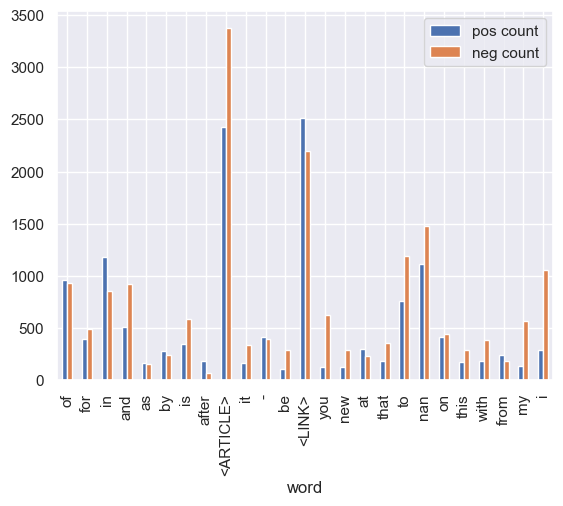

In [20]:
# Display and plot at most 40 words from the X_data set
plot_frequency(X_data, Y_data, max_word_num=40)

In [21]:
from collections import defaultdict

def length_plot(tweets_np , labels_np, interval_list):

    # initializes maps to count based on intervals of words
    pos_intervals = defaultdict(int)
    neg_intervals = defaultdict(int)

    # Convert the interval list into ranges for use below
    interval_map = {}
    for interval in interval_list:
        # Parses interval strings into useable ranges
        if '-' in interval:
            start, end = map(lambda x: int(x), interval.split('-'))
        else:
            start, end = interval.split('+')[0], 285

        interval_map[interval] = range(int(start), int(end) + 1)

    # Track the counts of positive and negative inputs for each range from above
    for entry_index in range(tweets_np.shape[0]):
        # Flatten all of the features into a single string
        words = ' '.join([str(feature) for feature in tweets_np[entry_index]]).split()

        for interval in interval_list:
            # Ignore words counts outside of our intervals
            if len(words) not in interval_map[interval]:
                continue

            # Updates the counts of positive and negative entries in the dictionary
            # based on the interval they are in
            if labels_np[entry_index]:
                pos_intervals[interval] += 1
            else:
                neg_intervals[interval] += 1

    # Create a Data Frame for the collected data
    result= {
        'interval' : [ interval for interval in interval_list],
        'pos intervals' : [pos_intervals[interval] for interval in interval_list],
        'neg intervals' : [neg_intervals[interval] for interval in interval_list]
    }
    word_count_df = pd.DataFrame(data = result , columns=['interval', 'pos intervals', 'neg intervals'])
    word_count_df = word_count_df.set_index('interval')

    # Plot and Display the collected data
    pd.concat([word_count_df[['pos intervals']], word_count_df[['neg intervals']]], axis=1).plot.bar()
    display(word_count_df)

    # Debugging code
    print(neg_intervals)
    print(pos_intervals)

,pos intervals,neg intervals
interval,,
0-5,2,28
6-10,164,463
11-15,740,1017
16-20,1041,1165
21-25,973,1010
26-30,317,552
31-35,34,106
36+,0,1


defaultdict(<class 'int'>, {'6-10': 463, '0-5': 28, '16-20': 1165, '11-15': 1017, '21-25': 1010, '26-30': 552, '31-35': 106, '36+': 1})
defaultdict(<class 'int'>, {'16-20': 1041, '6-10': 164, '21-25': 973, '11-15': 740, '26-30': 317, '31-35': 34, '0-5': 2, '36+': 0})


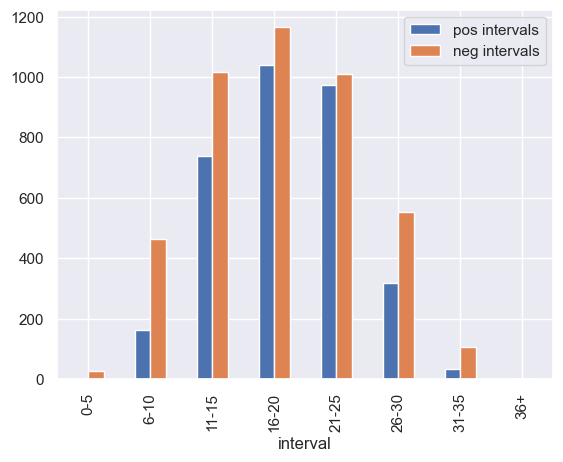

In [22]:
# Plots the count of positive and negative classes of X_data based on the given intervals
intervals = ['0-5', '6-10' , '11-15' , '16-20' , '21-25' , '26-30' , '31-35', '36+']
length_plot(X_data, Y_data, intervals)

## 4. Our Experiments

Preprocessing work and any functions will be defined below

In [23]:



def no_punc_no_link_(t):
    remove_regex = f'[{re.escape(string.punctuation)}]'
    space_regex = '...'
    result = tf.strings.lower(t)
    result = tf.strings.regex_replace(result, remove_regex, '')
    result = tf.strings.regex_replace(result, space_regex, ' ')


no_punc_no_link_('I.am.cool')

NameError: name 'tf' is not defined

In [ ]:
# TODO: Experiments


## 5. Error Analysis

In [ ]:
# TODO: Loss Analysis

## 6. Conclusion

TODO